In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna
import joblib

# To view the entire dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Optuna Logging
import optuna.logging
optuna.logging.set_verbosity(optuna.logging.WARNING) # To disable displaying trial results in hyperparameter tuning

# Read the data

In [2]:
borough = "Bronx" # "Manhattan" "Brooklyn" "Queens" "Staten Island" "Bronx" "EWR"
filename = rf"../../data/with_feature_engineering_totaled/{borough} - all txns.parquet.gz" #
df = pd.read_parquet(filename)

# Get the target column
target_col = "num_txns_All"
df.head()

,txn_date,quarter,month,day_of_month,txn_hour,week_day,is_weekend,is_monday,is_friday,is_holiday,is_holiday_next_day,is_holiday_previous_day,is_long_weekend,is_rush_hour,is_business_hour,is_night_hour,sin_hour,cos_hour,num_txns_All,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_72,lag_96,lag_120,lag_144,lag_164,lag_165,lag_166,lag_167,lag_168,lag_169,lag_68,lag_69,lag_70,lag_71,lag_73,lag_139,lag_140,lag_141,lag_142,lag_143,lag_145,lag_336,lag_504,lag_672,lag_840,lag_1008,lag_1176,lag_1344,rolling_avg_24_48_72_lags,std_24_48_72_lags,rolling_avg_w1-w4_lags,std_w1-w4_lags
timestamp_hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-01 00:00:00,2019-02-01,1,2,1,0,5,1,0,0,0,0.0,0.0,0,0,0,1,0.000000,1.000000,1901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 01:00:00,2019-02-01,1,2,1,1,5,1,0,0,0,0.0,0.0,0,0,0,1,0.258819,0.965926,1110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 02:00:00,2019-02-01,1,2,1,2,5,1,0,0,0,0.0,0.0,0,0,0,1,0.500000,0.866025,772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 03:00:00,2019-02-01,1,2,1,3,5,1,0,0,0,0.0,0.0,0,0,0,1,0.707107,0.707107,669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 04:00:00,2019-02-01,1,2,1,4,5,1,0,0,0,0.0,0.0,0,0,0,1,0.866025,0.500000,794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Train-Test split

We use January 2023 to July 2024 data as the training set and August 2024 as the test/holdout set.

In [3]:
from sklearn.preprocessing import StandardScaler

# Training data
df_train = (
    df
    [(df['txn_date'] >= '2023-01-01') & (df['txn_date'] < "2024-08-01")]
    .drop("txn_date", axis=1)
    #.dropna()
)
X_train = df_train.drop(target_col, axis=1).to_numpy()
y_train = df_train[target_col].to_numpy()

# Holdout data
df_test = (
    df
    [df['txn_date'] >= "2024-08-01"]
    .drop("txn_date", axis=1)
    .fillna(0) # is_holiday_next_day is causing NULLs since the information of the next days at the edges of the dataframe are unavailable
)

X_test = df_test.drop(target_col, axis=1).to_numpy()
y_test = df_test[target_col].to_numpy()

# Initialize StandardScaler
scaler = StandardScaler()

# Apply the standard scaler
X_train_scaled = scaler.fit_transform(X_train)

# Apply the scaling to the test set
X_test_scaled = scaler.transform(X_test)

# Feature names
feature_names = df_train.drop(target_col, axis=1).columns.to_list()

In [4]:
# Get columns with nulls in both train and test dataframes
train_nulls = df_train.isnull().sum()[df_train.isnull().sum() > 0].sort_values(ascending=False)
test_nulls = df_test.isnull().sum()[df_test.isnull().sum() > 0].sort_values(ascending=False)

print("Train Dataframe Null Columns:")
print(train_nulls)
print("\nTest Dataframe Null Columns:")
print(test_nulls)

Train Dataframe Null Columns:
Series([], dtype: int64)

Test Dataframe Null Columns:
Series([], dtype: int64)


<Axes: xlabel='timestamp_hour'>

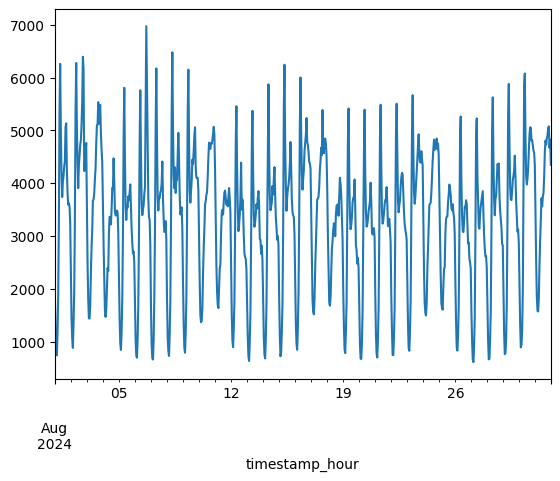

In [5]:
# Print the test set

df_test[target_col].plot()

# Modeling

### Evaluation helper function

In [6]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def calculate_mase(y_true, y_pred, hours_per_week=168):
    """Computes the MASE."""
    # Convert inputs to numpy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must have the same length")
    
    # Calculate errors for the actual predictions
    prediction_errors = np.abs(y_true - y_pred)
    
    # Calculate naive forecast errors
    if len(y_true) <= hours_per_week:
        raise ValueError(f"Length of y_true must be greater than hours_per_week ({hours_per_week})")
    
    # Calculate week-over-week naive forecast errors
    naive_errors = []
    for i in range(hours_per_week, len(y_true)):
        naive_forecast = y_true[i - hours_per_week]  # Use value from previous week
        naive_errors.append(abs(y_true[i] - naive_forecast))
    
    naive_errors = np.array(naive_errors)
    mean_naive_error = np.mean(naive_errors)
    
    if mean_naive_error == 0:
        raise ValueError("Mean naive error is zero, MASE cannot be computed")
    
    # Calculate MASE
    # For seasonal naive, we only consider errors after the first week
    mase = np.mean(prediction_errors[hours_per_week:]) / mean_naive_error
    
    return mase

# Function to calculate MAPE
def calculate_mape(y_true, y_pred):
    """Computes the MAPE."""
    return np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100

# We use this helper function to evaluate model performance
def evaluate(y_true, y_pred, printing=True):
    """
    This helper function prints the performance metrics of the model
    """
    # Evaluate the model using RMSE and MAE
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = calculate_mape(y_true, y_pred)
    mase = calculate_mase(y_true, y_pred)

    # Print the model metrics
    if printing:
        print(f'MAE: {mae}')
        print(f'MSE: {mse}')
        print(f'RMSE: {rmse}')
        print(f'R2: {r2}')
        print(f'MAPE: {mape}')
        print(f'MASE: {mase}\n')

    return {'RMSE': rmse, 'MAPE': mape, 'MASE': mase, 'MAE': mae, 'MSE': mse,  'R2': r2}

### Baseline

Use previous week's data

In [7]:
df_naive = pd.DataFrame(df[(df['txn_date'] >= '2024-07-25') & (df['txn_date'] <= '2024-08-31')][target_col])
df_naive['forecast_d-1'] = df_naive[target_col].shift(24)
df_naive['forecast_w-1'] = df_naive[target_col].shift(7 * 24)
df_naive = df_naive[df['txn_date'] >= '2024-08-01'] # Filter Aug 2024 data
display(df_naive.head())

print("d-1")
_ = evaluate(df_naive[target_col], df_naive["forecast_d-1"])
print("\n")

print("W-1")
naive_eval_metrics_test = evaluate(df_naive[target_col], df_naive["forecast_w-1"])

C:\Users\tonba\AppData\Local\Temp\ipykernel_23928\3718523736.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_naive = df_naive[df['txn_date'] >= '2024-08-01'] # Filter Aug 2024 data


,num_txns_All,forecast_d-1,forecast_w-1
timestamp_hour,,,
2024-08-01 00:00:00,1945,1777.0,2031.0
2024-08-01 01:00:00,1221,1130.0,1160.0
2024-08-01 02:00:00,827,773.0,788.0
2024-08-01 03:00:00,739,778.0,766.0
2024-08-01 04:00:00,1166,1086.0,1061.0


d-1
MAE: 493.64247311827955
MSE: 569033.5564516129
RMSE: 754.3431291207025
R2: 0.6721217801821587
MAPE: 16.99546658856538
MASE: 2.2357745325052036



W-1
MAE: 231.43010752688173
MSE: 144570.23924731184
RMSE: 380.2239330280405
R2: 0.9166983525916564
MAPE: 6.848641711509088
MASE: 1.0



### Ridge Regression

In [8]:
from sklearn.linear_model import Ridge

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameter search space for alpha
    alpha = trial.suggest_float('alpha', 1e-5, 1e5, log=True)  # Log scale search for alpha
    
    # Ridge regression model with the suggested alpha value
    ridge_model = Ridge(alpha=alpha)
    
    # Fit the model
    ridge_model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred_ridge = ridge_model.predict(X_test_scaled)
    
    # Calculate the mean squared error
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
    
    return rmse  

# Create the Optuna study and optimize
study = optuna.create_study(direction='minimize')  # Minimize RMSE
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=-1)  # Number of trials to run

# Get the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Train the final model with the best alpha
ridge_model = Ridge(alpha=best_params['alpha'])
ridge_model.fit(X_train_scaled, y_train)

# Make predictions with the best model
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Evaluate the final model
print("Train")
ridge_eval_metrics_train = evaluate(y_train, ridge_model.predict(X_train_scaled))
print("Test")
ridge_eval_metrics_test = evaluate(y_test, y_pred_ridge)

  0%|          | 0/100 [00:00<?, ?it/s]

Best hyperparameters: {'alpha': 504.16069126013235}
Train
MAE: 261.3977636988081
MSE: 186147.6419067391
RMSE: 431.44830734021787
R2: 0.9009774613183511
MAPE: 8.804631265867277
MASE: 0.855150122880322

Test
MAE: 189.71010119827866
MSE: 86307.31358748002
RMSE: 293.7810640383073
R2: 0.9502695614072639
MAPE: 5.996176108831187
MASE: 0.8229757660240111



### Decision Tree

In [9]:
from sklearn.tree import DecisionTreeRegressor

def objective(trial):
    # Suggest hyperparameters to tune
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    # Initialize the model with the suggested hyperparameters
    dt_model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Train the model
    dt_model.fit(X_train, y_train)
    
    # Evaluate the model on the validation set (or test set if needed)
    y_pred = dt_model.predict(X_test)
    
    # Calculate the mean squared error
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse  # Optuna will try to minimize this

# Hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=-1)

# Get the best model
best_params = study.best_params
dt_model = DecisionTreeRegressor(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(X_test)

# Model evaluation
print("Train")
dt_eval_metrics_train = evaluate(y_train, dt_model.predict(X_train))
print("Test")
dt_eval_metrics_test = evaluate(y_test, y_pred_dt)

  0%|          | 0/100 [00:00<?, ?it/s]

Train
MAE: 221.11899801781624
MSE: 115919.0171396535
RMSE: 340.4688196291307
R2: 0.9383360689339224
MAPE: 7.006783364775185
MASE: 0.726638460612243

Test
MAE: 197.84585665690275
MSE: 94912.80964124847
RMSE: 308.0792262409922
R2: 0.9453110581788187
MAPE: 6.161976088832474
MASE: 0.8279482410118802



### Random Forest

In [10]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the random forest regressor
rf_model = RandomForestRegressor(n_estimators=300, 
                                 max_depth=6, 
                                 n_jobs=-1, 
                                 random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Model evaluation
print("Train")
rf_eval_metrics_train = evaluate(y_train, rf_model.predict(X_train))
print("Test")
rf_eval_metrics_test = evaluate(y_test, y_pred_rf)

Train
MAE: 238.5079667828723
MSE: 144582.43195915423
RMSE: 380.2399662833383
R2: 0.923088365156218
MAPE: 7.732107293234658
MASE: 0.7810367336308116

Test
MAE: 181.73279782182456
MSE: 83606.85979160451
RMSE: 289.14850819536406
R2: 0.9518255680315715
MAPE: 5.656366056818818
MASE: 0.7522002558102937



### XGBoost (with hyperparameter tuning)

In [11]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters for tuning
    param = {
        'objective': 'reg:squarederror',
        'n_estimators': 300, # Keep fixed
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 7), # keep this low enough to avoid overfitting
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e2, log=True), # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1e2, log=True), # L2 regularization
        'n_jobs': -1,
        'random_state': 42,
        'verbosity': 0
    }
    
    # Initialize the XGBoost regressor with the suggested hyperparameters
    model = xgb.XGBRegressor(**param)
    
    # Fit the model
    model.fit(X_train, y_train, verbose=False)
    
    # Predict on the validation set
    y_pred = model.predict(X_test)
    
    # Calculate root mean squared error as the objective to minimize
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse
    
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=60, show_progress_bar=True)

# Get the best hyperparameters found by Optuna
best_params = study.best_params
print("Best hyperparameters found: ", best_params)

# Train the best model
xgb_model = xgb.XGBRegressor(**best_params, n_estimators=300, n_jobs = -1, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgboost = xgb_model.predict(X_test)

# Model evaluation
print("Train")
xgb_eval_metrics_train = evaluate(y_train, xgb_model.predict(X_train))
print("Test")
xgb_eval_metrics_test = evaluate(y_test, y_pred_xgboost)

  0%|          | 0/60 [00:00<?, ?it/s]

Best hyperparameters found:  {'learning_rate': 0.056935561604781956, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.785287322650813, 'colsample_bytree': 0.7591291209397268, 'gamma': 0.9923923598119287, 'reg_alpha': 3.820086799578746, 'reg_lambda': 0.037208764182049665}
Train
MAE: 96.1817673598594
MSE: 18380.713054367916
RMSE: 135.5754883980431
R2: 0.9902222512690527
MAPE: 3.2836862074738757
MASE: 0.319383440719325

Test
MAE: 156.02903132284843
MSE: 65795.36597873455
RMSE: 256.5060739607048
R2: 0.9620885847156445
MAPE: 4.751688226079764
MASE: 0.6556200731255735



#### Feature Importances of the XGBoost model

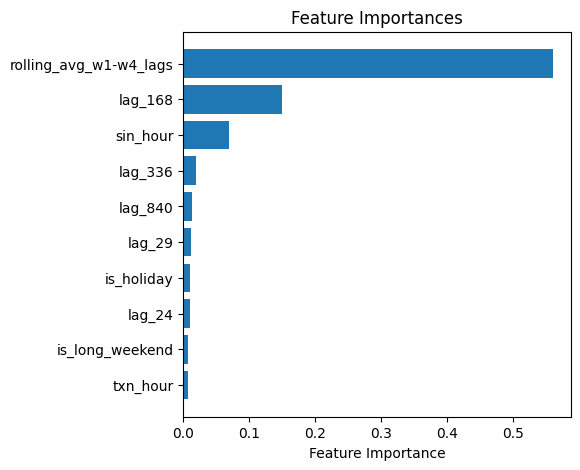

In [12]:
feature_impt = dict(zip(feature_names, xgb_model.feature_importances_))

# Sort the dictionary by feature importance in descending order
k = 10
top_k_importance = dict(sorted(feature_impt.items(), 
                                key=lambda item: item[1], reverse=True)[:k])

# Extract the feature names and importances for plotting
features = list(top_k_importance.keys())[::-1]
importances = list(top_k_importance.values())[::-1]

# Plot the feature importances
plt.figure(figsize=(5, 5))
plt.barh(features, importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.savefig(rf"../../data/images/{borough} - XGBoost model feature importances.jpeg", dpi=300, bbox_inches='tight')
plt.show()

#### SHAP on XGBoost model

[02:41:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


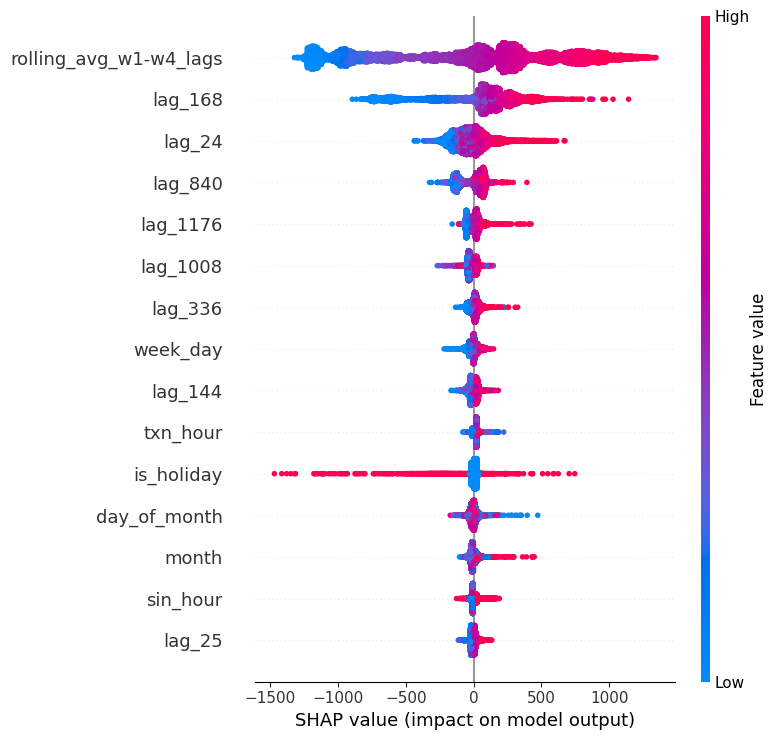

In [13]:
import shap

# Initialize SHAP explainer for the XGBoost model
explainer = shap.TreeExplainer(xgb_model, n_jobs=-1)

# Compute SHAP values for the dataset (assuming X_train is your input data)
shap_values = explainer.shap_values(X_train)

# Plot summary of SHAP values (feature importances)
shap.summary_plot(shap_values, X_train, feature_names=feature_names, show=False, max_display=15)

# Save the plot as a JPEG file
plt.savefig(rf"../../data/images/{borough} - XGBoost model SHAP beeswarm plot.jpeg", dpi=300, bbox_inches='tight')
plt.show()

### Deep Neural Network

In [14]:
from sklearn.neural_network import MLPRegressor

# Fit the regression model
nn_model = MLPRegressor(hidden_layer_sizes=(200, 150, 120, 90, 70),
                        activation="relu",
                        solver="adam", 
                        learning_rate="adaptive", # Changing learning rate
                        learning_rate_init=0.1, # Initial learning rate
                        momentum=0.9, # Avoid local minima
                        alpha=10, # Regularization
                        max_iter=500,
                        tol=1e-7,
                        random_state=42, 
                        verbose=True,
                        shuffle=False # NOTE THAT THIS IS TIME SERIES DATA NO SHUFFLING ALLOWED
                       )
nn_model.fit(X_train_scaled, y_train) # Use scaled data

# Make predictions
y_pred_nn = nn_model.predict(X_test_scaled) # Use scaled data

# Model evaluation
print("Train")
nn_eval_metrics_train = evaluate(y_train, nn_model.predict(X_train_scaled))
print("Test")
nn_eval_metrics_test = evaluate(y_test, y_pred_nn)

Iteration 1, loss = 4536238.06299700
Iteration 2, loss = 378217.54530103
Iteration 3, loss = 232593.22566549
Iteration 4, loss = 266894.42443877
Iteration 5, loss = 146874.72122810
Iteration 6, loss = 122755.33603345
Iteration 7, loss = 120309.22737118
Iteration 8, loss = 117811.81415352
Iteration 9, loss = 111051.82936151
Iteration 10, loss = 102844.81659941
Iteration 11, loss = 96133.67277124
Iteration 12, loss = 93062.08612229
Iteration 13, loss = 101150.41881658
Iteration 14, loss = 99569.09671165
Iteration 15, loss = 100127.19234574
Iteration 16, loss = 94432.21321042
Iteration 17, loss = 91979.95697082
Iteration 18, loss = 91329.19177103
Iteration 19, loss = 191520.22012772
Iteration 20, loss = 157405.65683413
Iteration 21, loss = 87414.59134861
Iteration 22, loss = 77412.85582744
Iteration 23, loss = 87266.55868810
Iteration 24, loss = 77065.06790956
Iteration 25, loss = 69726.10209812
Iteration 26, loss = 87811.85897128
Iteration 27, loss = 71306.67306504
Iteration 28, loss = 6

### FB Prophet

In [15]:
from prophet import Prophet

# Prophet has specific formatting
df_prophet = df.copy()
df_prophet = df_prophet.reset_index()
df_prophet['timestamp_hour'] = pd.to_datetime(df_prophet['timestamp_hour'])
df_prophet = df_prophet.sort_values(by='timestamp_hour')
df_prophet = df_prophet.rename(columns = {'num_txns_All': 'y', 'timestamp_hour': 'ds'})
df_prophet = df_prophet[['ds', 'y', 'rolling_avg_w1-w4_lags']]

# Train test split
df_hist_prophet = df_prophet[df_prophet['ds'] < '2024-08-01'].dropna()
df_test_prophet = df_prophet[df_prophet['ds']>= '2024-08-01']

# Best prophet model
best_prophet = joblib.load(f'../../models/prophet/{borough}_Prophet.joblib')

# New prophet model but with exogenous variables
prophet_model = Prophet(changepoint_prior_scale=best_prophet.changepoint_prior_scale,
                        seasonality_prior_scale=best_prophet.seasonality_prior_scale,
                        holidays_prior_scale=best_prophet.holidays_prior_scale,
                        seasonality_mode=best_prophet.seasonality_mode,
                        yearly_seasonality=best_prophet.yearly_seasonality,
                        weekly_seasonality=best_prophet.weekly_seasonality,
                        daily_seasonality=best_prophet.daily_seasonality)

# Add exogenous variables as regressors
prophet_model.add_regressor('rolling_avg_w1-w4_lags')

# Add custom hourly seasonality (you can adjust the period if needed)
prophet_model.add_seasonality(name='hourly', period=24, fourier_order=8)

# Fit the model
prophet_model.fit(df_hist_prophet)

# Forecast
y_pred_prophet = prophet_model.predict(df_test_prophet)
prophet_eval_metrics_test = evaluate(df_test_prophet['y'], y_pred_prophet['yhat'])

02:41:35 - cmdstanpy - INFO - Chain [1] start processing
02:42:12 - cmdstanpy - INFO - Chain [1] done processing


MAE: 179.85552902218095
MSE: 84656.61941180182
RMSE: 290.958105939329
R2: 0.951220694537549
MAPE: 5.845549280586424
MASE: 0.7302597908600958



### FB Prophet + GARCH

In [16]:
from arch import arch_model

# Specify the residuals from the Prophet model
prophet_residuals = df_test_prophet['y'].values - y_pred_prophet['yhat'].values

# Use Prophet to predict mu (trend/seasonality)
predicted_mu = y_pred_prophet['yhat']

def objective(trial):
    # Suggest values for p and q
    p = trial.suggest_int('p', 1, 30)  # GARCH order (p)
    q = trial.suggest_int('q', 1, 30)  # ARCH order (q)
    
    # Fit the GARCH model with the suggested hyperparameters
    garch_model = arch_model(prophet_residuals, vol='Garch', p=p, q=q, rescale=False)
    garch_fit = garch_model.fit(disp='off')
    
    # Forecast residuals for the next 10 periods (horizon)
    garch_forecast = garch_fit.forecast(horizon=10)
    predicted_et = garch_forecast.mean['h.01'].iloc[-1]
    
    # Combine predictions (yt = mu + et)
    y_pred_garch = np.array(predicted_mu + predicted_et)
    
    # Evaluate the GARCH model (you need to define `evaluate` function)
    garch_eval_metrics_test = evaluate(y_test, y_pred_garch, printing=False)
    
    # Return the evaluation metric, assuming lower is better (e.g., MASE, RMSE)
    return garch_eval_metrics_test['RMSE']  # Change this depending on your evaluation metric

# Create an Optuna study to optimize the hyperparameters
study = optuna.create_study(direction='minimize')  # Minimize the evaluation metric (e.g., MAE)

# Run the optimization for 50 trials
study.optimize(objective, n_trials=20, show_progress_bar=True, n_jobs=-1)

# Train the final Prophet+GARCH model
# Best p and q for GARCH
best_p = study.best_params['p']
best_q = study.best_params['q']

# Fit GARCH model to Prophet's residuals
garch_model = arch_model(prophet_residuals, vol='Garch', p=best_p, q=best_q, rescale=False)
garch_fit = garch_model.fit(disp='off')

# Use GARCH to predict the residual (et)
garch_forecast = garch_fit.forecast(horizon=10)
predicted_et = garch_forecast.mean['h.01'].iloc[-1]

# Combine predictions (yt = mu (from Prophet) + et) 
y_pred_garch = np.array(predicted_mu + predicted_et)

# Evaluate the GARCH model
garch_eval_metrics_test = evaluate(y_test, y_pred_garch)

  0%|          | 0/20 [00:00<?, ?it/s]

MAE: 180.08632380866592
MSE: 83113.07124251465
RMSE: 288.29337703546827
R2: 0.9521100899347289
MAPE: 5.830178689494119
MASE: 0.7293334266623304



# Model Comparisons

### Time Series Plots

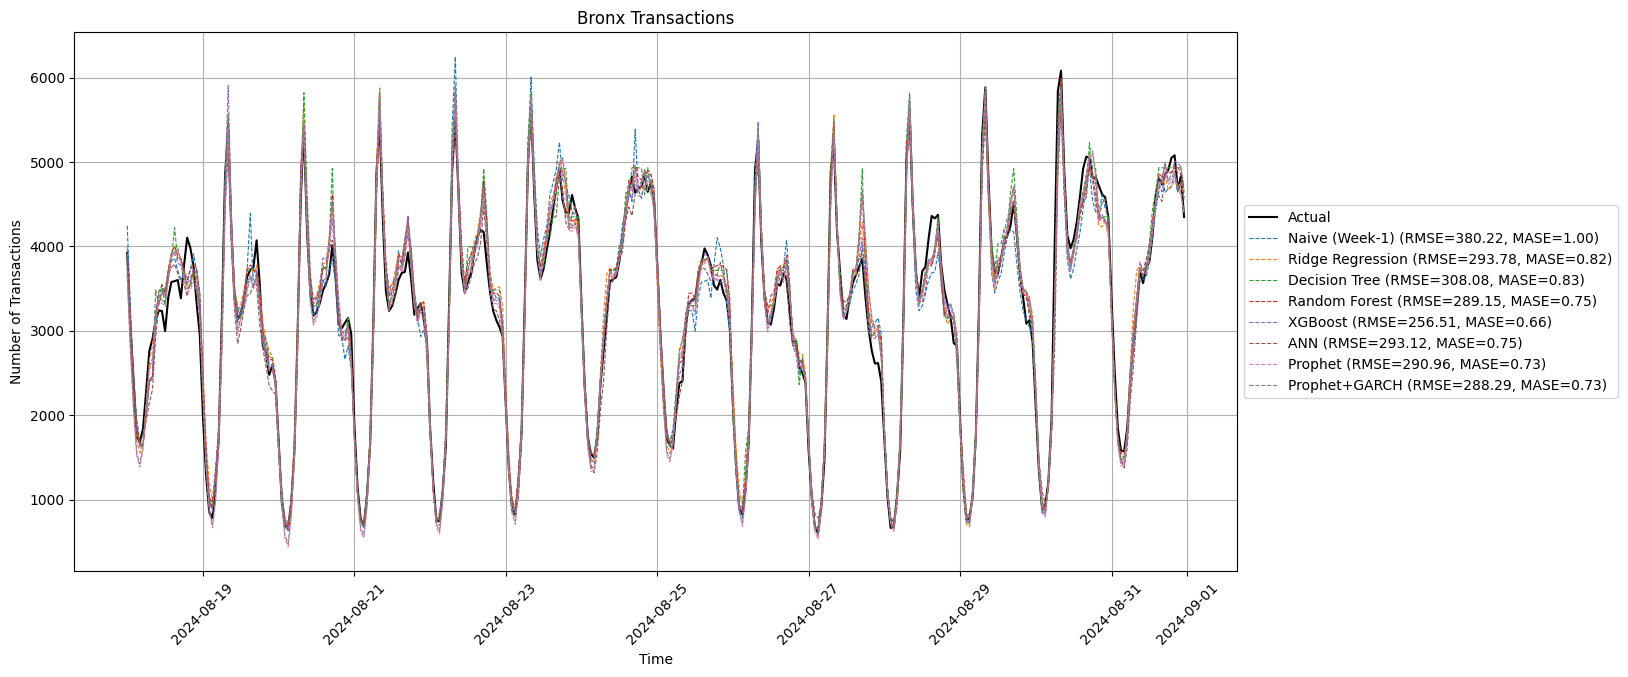

In [17]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 7))

num_hrs = 168 * 2 # plot only the last 2 weeks
# Plotting the predictions
ax.plot(df_test.index[-num_hrs:], df_test[target_col][-num_hrs:], label="Actual", color='black', lw=1.5)
ax.plot(df_test.index[-num_hrs:], df_naive["forecast_w-1"][-num_hrs:], label=f"Naive (Week-1) (RMSE={naive_eval_metrics_test['RMSE']:.2f}, MASE={naive_eval_metrics_test['MASE']:.2f})", ls='--', lw=.8)
ax.plot(df_test.index[-num_hrs:], y_pred_ridge[-num_hrs:], label=f"Ridge Regression (RMSE={ridge_eval_metrics_test['RMSE']:.2f}, MASE={ridge_eval_metrics_test['MASE']:.2f})", ls='--', lw=.8)
ax.plot(df_test.index[-num_hrs:], y_pred_dt[-num_hrs:], label=f"Decision Tree (RMSE={dt_eval_metrics_test['RMSE']:.2f}, MASE={dt_eval_metrics_test['MASE']:.2f})", ls='--', lw=.8)
ax.plot(df_test.index[-num_hrs:], y_pred_rf[-num_hrs:], label=f"Random Forest (RMSE={rf_eval_metrics_test['RMSE']:.2f}, MASE={rf_eval_metrics_test['MASE']:.2f})", ls='--', lw=.8)
ax.plot(df_test.index[-num_hrs:], y_pred_xgboost[-num_hrs:], label=f"XGBoost (RMSE={xgb_eval_metrics_test['RMSE']:.2f}, MASE={xgb_eval_metrics_test['MASE']:.2f})", ls='--', lw=.8)
ax.plot(df_test.index[-num_hrs:], y_pred_nn[-num_hrs:], label=f"ANN (RMSE={nn_eval_metrics_test['RMSE']:.2f}, MASE={nn_eval_metrics_test['MASE']:.2f})", ls='--', lw=.8)
ax.plot(df_test.index[-num_hrs:], y_pred_prophet["yhat"].to_numpy()[-num_hrs:], label=f"Prophet (RMSE={prophet_eval_metrics_test['RMSE']:.2f}, MASE={prophet_eval_metrics_test['MASE']:.2f})", ls='--', lw=.8)
ax.plot(df_test.index[-num_hrs:], y_pred_garch[-num_hrs:], label=f"Prophet+GARCH (RMSE={garch_eval_metrics_test['RMSE']:.2f}, MASE={garch_eval_metrics_test['MASE']:.2f})", ls='--', lw=.8)

# Adding labels, title, and legend for better clarity
ax.set_xlabel('Time')
ax.set_ylabel('Number of Transactions')
ax.set_title(f'{borough} Transactions')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels 45 degrees

img_filename = rf"../../data/results/{borough} - test set performance comparison.jpeg"
plt.savefig(img_filename, dpi=300, bbox_inches='tight')
plt.show()

### XGBoost and Naive Model only

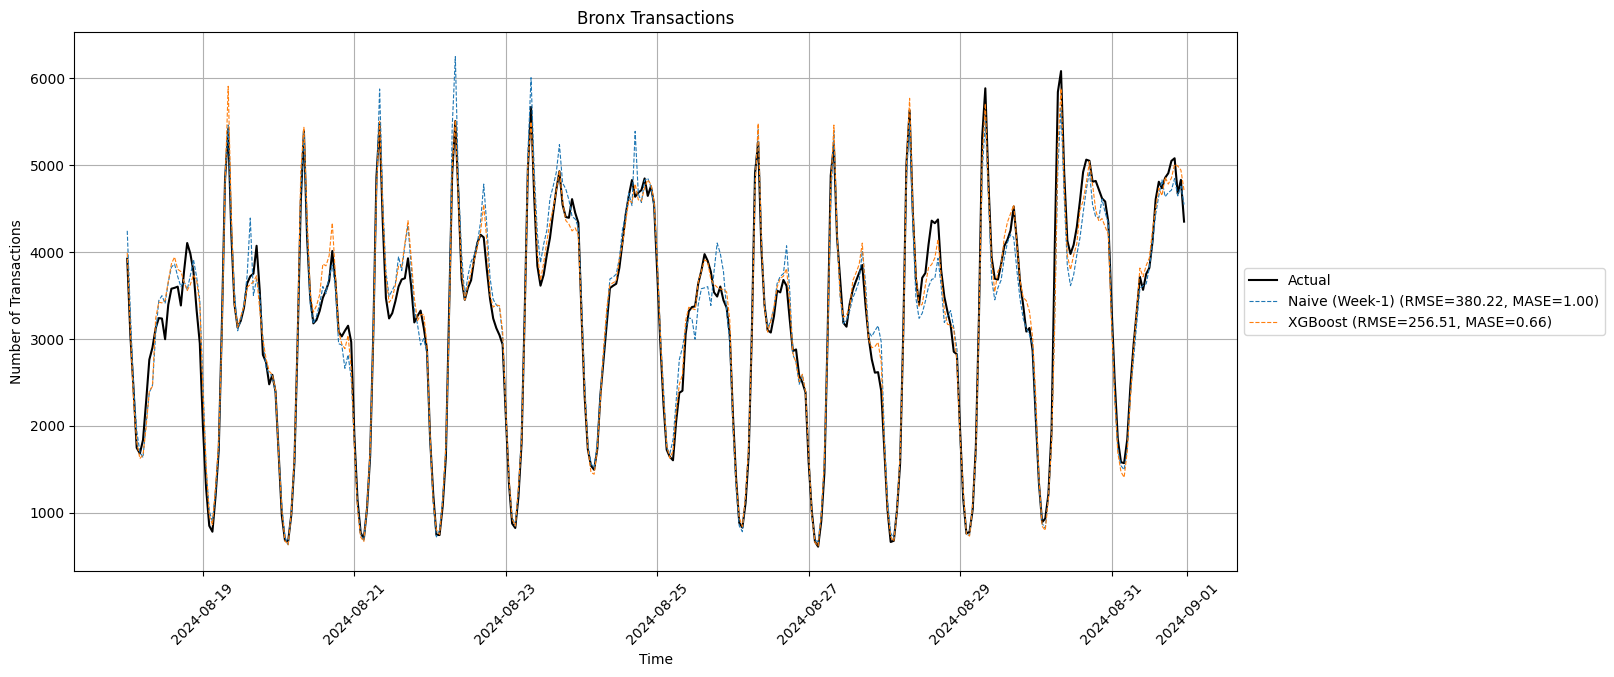

In [18]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 7))

num_hrs = 168 * 2 # plot only the last 2 weeks
# Plotting the predictions
ax.plot(df_test.index[-num_hrs:], df_test[target_col][-num_hrs:], label="Actual", color='black', lw=1.5)
ax.plot(df_test.index[-num_hrs:], df_naive["forecast_w-1"][-num_hrs:], label=f"Naive (Week-1) (RMSE={naive_eval_metrics_test['RMSE']:.2f}, MASE={naive_eval_metrics_test['MASE']:.2f})", ls='--', lw=.8)
ax.plot(df_test.index[-num_hrs:], y_pred_xgboost[-num_hrs:], label=f"XGBoost (RMSE={xgb_eval_metrics_test['RMSE']:.2f}, MASE={xgb_eval_metrics_test['MASE']:.2f})", ls='--', lw=.8)

# Adding labels, title, and legend for better clarity
ax.set_xlabel('Time')
ax.set_ylabel('Number of Transactions')
ax.set_title(f'{borough} Transactions')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels 45 degrees

img_filename = rf"../../data/results/{borough} - test set performance comparison (XGBoost only).jpeg"
plt.savefig(img_filename, dpi=300, bbox_inches='tight')
plt.show()

### Model Performance

In [19]:
# Create a dictionary mapping model names to their metrics
models_dict = {
    'Naive (W-1)': naive_eval_metrics_test,
    'Ridge Regression': ridge_eval_metrics_test,
    'Decision Tree': dt_eval_metrics_test,
    'Random Forest': rf_eval_metrics_test,
    'XGBoost': xgb_eval_metrics_test,
    'Neural Network': nn_eval_metrics_test,
    'Prophet': prophet_eval_metrics_test,
    'Prophet + GARCH': garch_eval_metrics_test
}

# Convert to DataFrame
df_metrics = pd.DataFrame.from_dict(models_dict, orient='index')
df_metrics["borough"] = borough
df_metrics = df_metrics[["borough", "RMSE", "MAPE", "MASE", "MAE"]].fillna(0)

csv_filename = rf"../../data/results/{borough} - model metrics.csv"
df_metrics.to_csv(csv_filename)
df_metrics.head(4)

,borough,RMSE,MAPE,MASE,MAE
Naive (W-1),Bronx,380.223933,6.848642,1.000000,231.430108
Ridge Regression,Bronx,293.781064,5.996176,0.822976,189.710101
Decision Tree,Bronx,308.079226,6.161976,0.827948,197.845857
Random Forest,Bronx,289.148508,5.656366,0.752200,181.732798


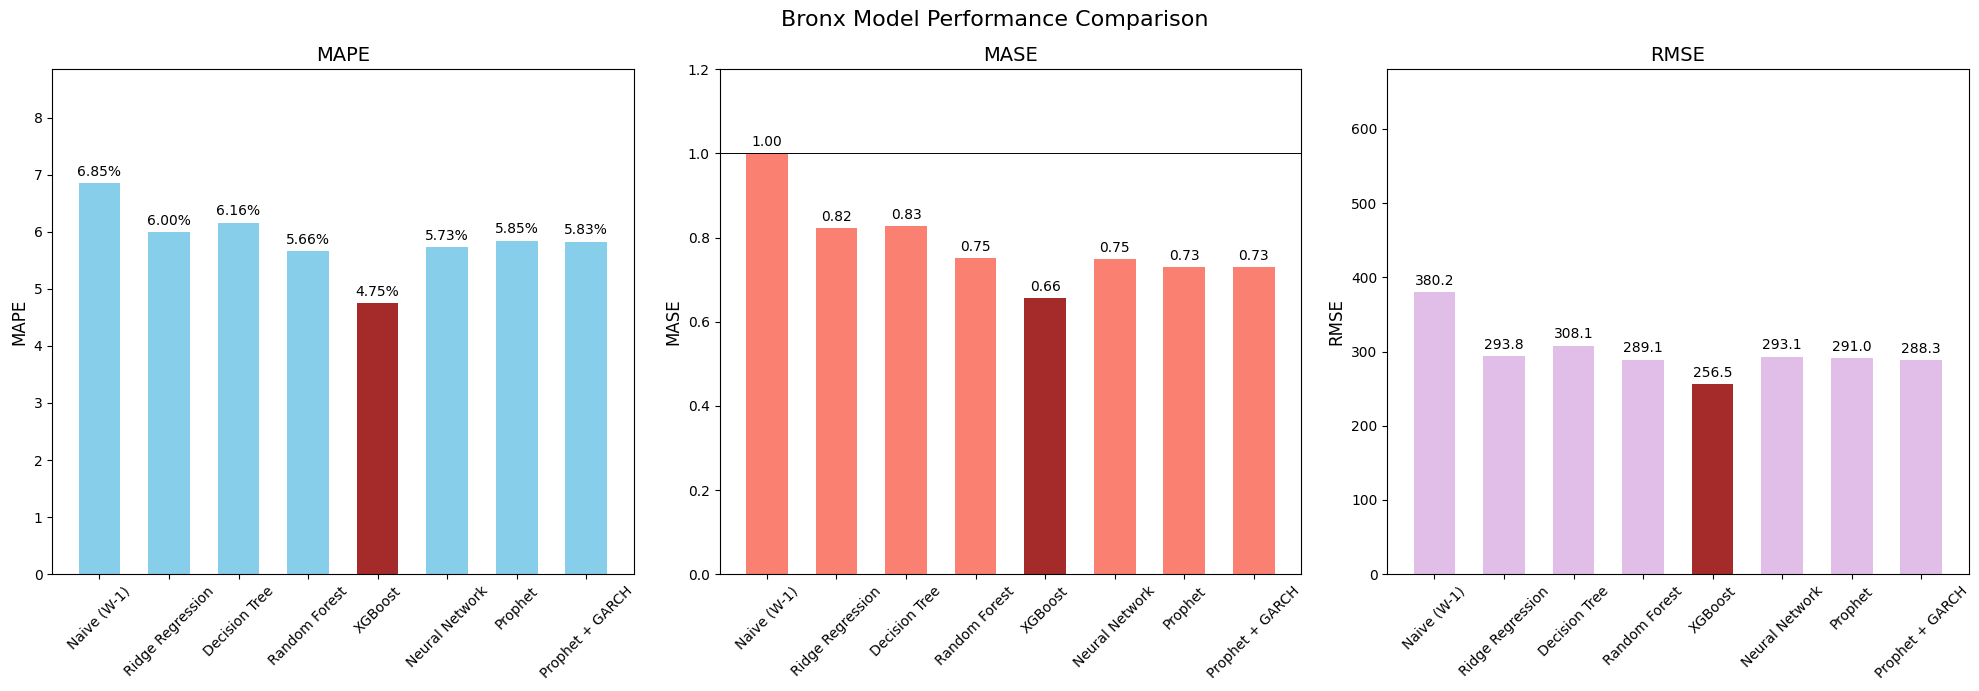

In [20]:
# Bar plots for MAPE and MASE
x = np.arange(len(df_metrics.index))  # the label locations

# Subplot
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Highlight only the best models
mape_best_model = df_metrics["MAPE"].sort_values().index[0]
colors_mape = ['skyblue' if model != mape_best_model else '#A52A2A' for model in df_metrics.index]

mase_best_model = df_metrics["MASE"].sort_values().index[0]
colors_mase = ['salmon' if model != mase_best_model else '#A52A2A' for model in df_metrics.index]

rmse_best_model = df_metrics["RMSE"].sort_values().index[0]
colors_rmse = ['#E1BEE7' if model != rmse_best_model else '#A52A2A' for model in df_metrics.index]

# Subplot 1: MAPE
axes[0].bar(x, df_metrics['MAPE'], color=colors_mape, width=0.6)
axes[0].set_title('MAPE', fontsize=14)
axes[0].set_ylabel('MAPE', fontsize=12)
axes[0].set_xticks(x)
axes[0].set_xticklabels(df_metrics.index, rotation=45, fontsize=10)
axes[0].bar_label(axes[0].containers[0], fmt='%.2f%%', padding=3)
axes[0].set_ylim(0, df_metrics['MAPE'].max() + 2)

# Subplot 2: MASE
axes[1].bar(x, df_metrics['MASE'], color=colors_mase, width=0.6)
axes[1].axhline(y=1, color='black', lw=.7)
axes[1].set_title('MASE', fontsize=14)
axes[1].set_ylabel('MASE', fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels(df_metrics.index, rotation=45, fontsize=10)
axes[1].bar_label(axes[1].containers[0], fmt='%.2f', padding=3)
axes[1].set_ylim(0, df_metrics['MASE'].max() + .2)

# Sublot 3: RMSE
axes[2].bar(x, df_metrics['RMSE'], color=colors_rmse, width=0.6)
axes[2].set_title('RMSE', fontsize=14)
axes[2].set_ylabel('RMSE', fontsize=12)
axes[2].set_xticks(x)
axes[2].set_xticklabels(df_metrics.index, rotation=45, fontsize=10)
axes[2].bar_label(axes[2].containers[0], fmt='%.1f', padding=3)
axes[2].set_ylim(0, df_metrics['RMSE'].max() + 300)

# Add a suptitle for the entire figure
fig.suptitle(f'{borough} Model Performance Comparison', fontsize=16)

# Adjust layout and show
fig.tight_layout()

# Save the figure
img_filename = rf"../../data/results/{borough} - metrics comparison.jpeg"
plt.savefig(img_filename, dpi=300, bbox_inches='tight')
plt.show();

### ADF test and ACF+PACF

In [ ]:
# from statsmodels.tsa.stattools import adfuller

# time_series = df[(df['txn_date'] >= '2023-01-01') & (df['txn_date'] <= '2024-12-01')][target_col].to_numpy()
# result = adfuller(time_series)
# print('ADF Statistic: %f' % result[0])
# print('p-value:', result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#     print('\t%s: %.3f' % (key, value))



# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# # Time series data
# time_series = df[(df['txn_date'] >= '2023-01-01') & (df['txn_date'] < "2024-08-01")]["num_txns_All"]

# # Max time lag 
# lag = 200

# # Tick positions
# tick_positions = np.arange(0, lag + 1, 24)  # From 0 to max(x) in steps of 24
# tick_labels = [int(t) for t in tick_positions]  # Custom labels

# # Plot ACF and PACF
# fig, ax = plt.subplots(2, 1, figsize=(15, 7))

# # Autocorrelation (ACF)
# plot_acf(
#     time_series,
#     ax=ax[0],
#     lags=lag,
#     vlines_kwargs={"linewidth": 0.5},  # Adjust line width
#     markersize=3  # Adjust marker size
# )
# ax[0].set_title(f"{borough} ACF")
# ax[0].set_xlabel("Hours")
# ax[0].set_xticks(tick_positions)  # Set tick positions
# ax[0].set_xticklabels(tick_labels)  # Set custom labels
# ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid

# # Partial Autocorrelation (PACF)
# plot_pacf(
#     time_series,
#     ax=ax[1],
#     lags=lag,
#     method='ywm',
#     vlines_kwargs={"linewidth": 0.5},  # Adjust line width
#     markersize=3  # Adjust marker size
# )
# ax[1].set_title(f"{borough} PACF")
# ax[1].set_xlabel("Hours")
# ax[1].set_xticks(tick_positions)  # Set tick positions
# ax[1].set_xticklabels(tick_labels)  # Set custom labels
# ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid

# fig.tight_layout()
# plt.savefig(rf"../../data/images/acf_pacf_{borough}.jpeg", dpi=300)
# plt.show()